## Step 1, importing libraries

Python runs off multiple different libraries which you can import. To install a library, you usually have to run 'pip install [library]' into the terminal at the bottom of the screen. For this you need to have the following libraries:


In [21]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os

These are 4 very useful scraping libraries. Pandas lets you build dataframes, requests allows you to access urls, beautifulsoup lets you get what you need from different websites, and os allows you to create folders and save files onto your actual system. 

Now for the first function:

In [22]:
def get_team_url(team_name):
    # This is for the premier league
    premier_league_url = "https://fbref.com/en/comps/9/Premier-League-Stats"
   
    # Send request to the URL
    response = requests.get(premier_league_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # ID of table we want
    table = soup.find('table', {'id': 'results2023-202491_overall'})

    # // Find all team names in the table and print them
    team_names = []
    for row in table.find_all('tr')[1:]:
        columns = row.find_all('td')
        if len(columns) > 1:
            team_names.append(columns[1].text.strip())
    
    # Extract hyperlinks from table
    for link in table.find_all('a'):
        href = link.get('href')
        if href and '/en/squads' in href and team_name in link.text:
            return f'https://fbref.com{href}'
        
    # Failsafe if team not found
    print('Team not found')
    return None

Functions in Python are really useful. Once defined you can run them however you want. This function essentially begins on the first link you see, https://fbref.com/en/comps/9/Premier-League-Stat, and then navigates from there. All we're doing here is automating stuff you would normally have to click on. Press on the link and see where we begin to get an idea of what the code is doing.

    response = requests.get(premier_league_url)
    soup = BeautifulSoup(response.content, 'html.parser')

This code is using the requests module to click on the link. Think of this as the computer clicking on the link internally, just the same way you pressed on the link above.

    table = soup.find('table', {'id': 'results2023-202491_overall'}) 

This code is slightly more technical. Scroll down on the open fbref link. What I want to do is to locate this table:

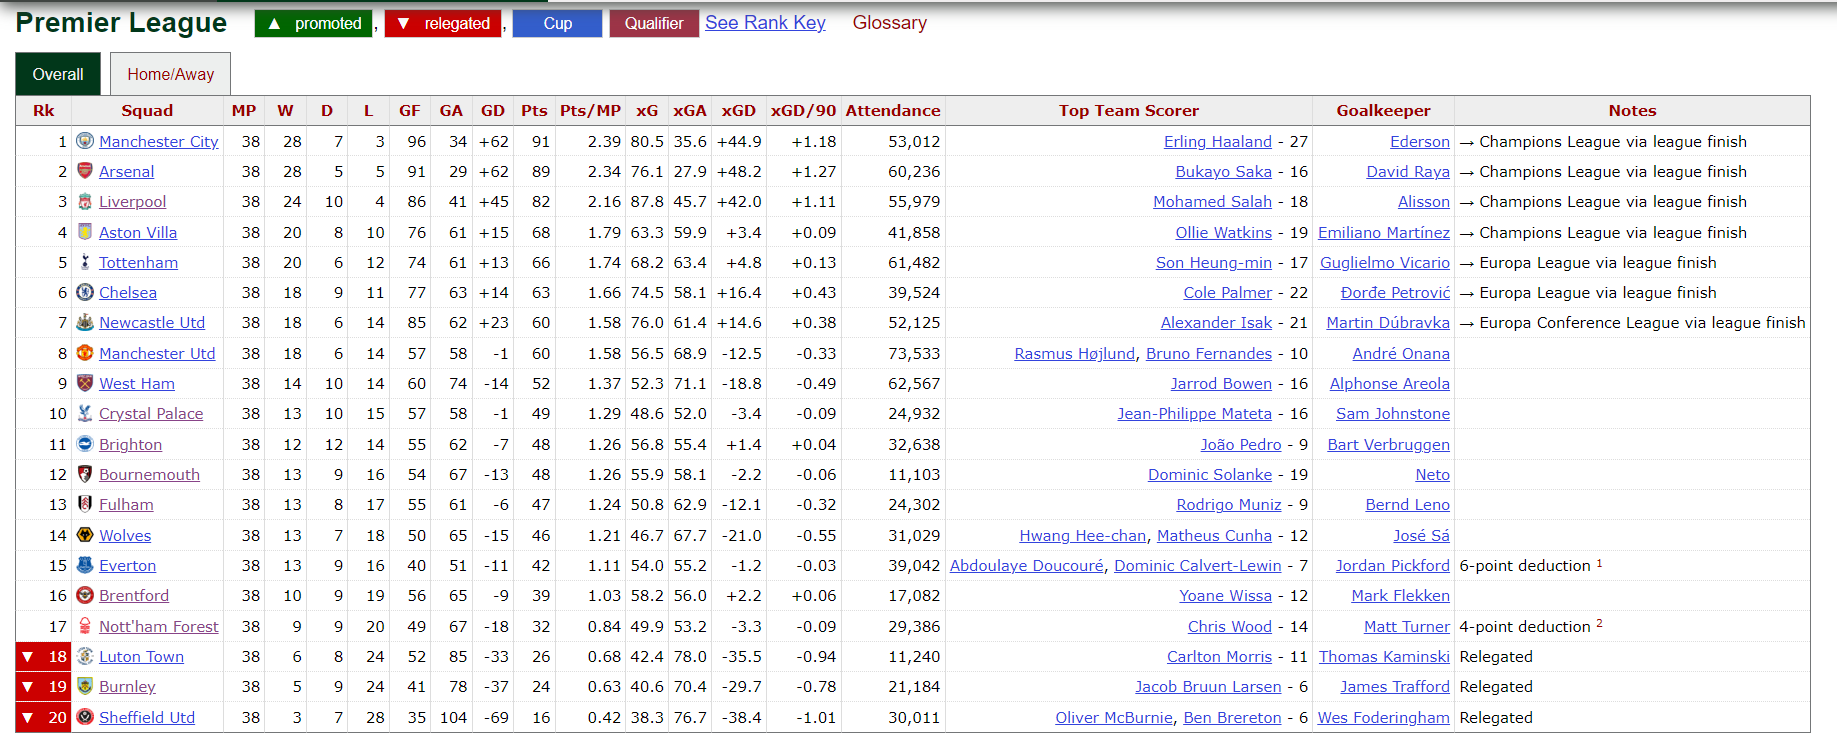

When scraping, the best tool you can have is inspect element. Right click anywhere on the page and go to inspect. A scary looking table should appear that looks like this:

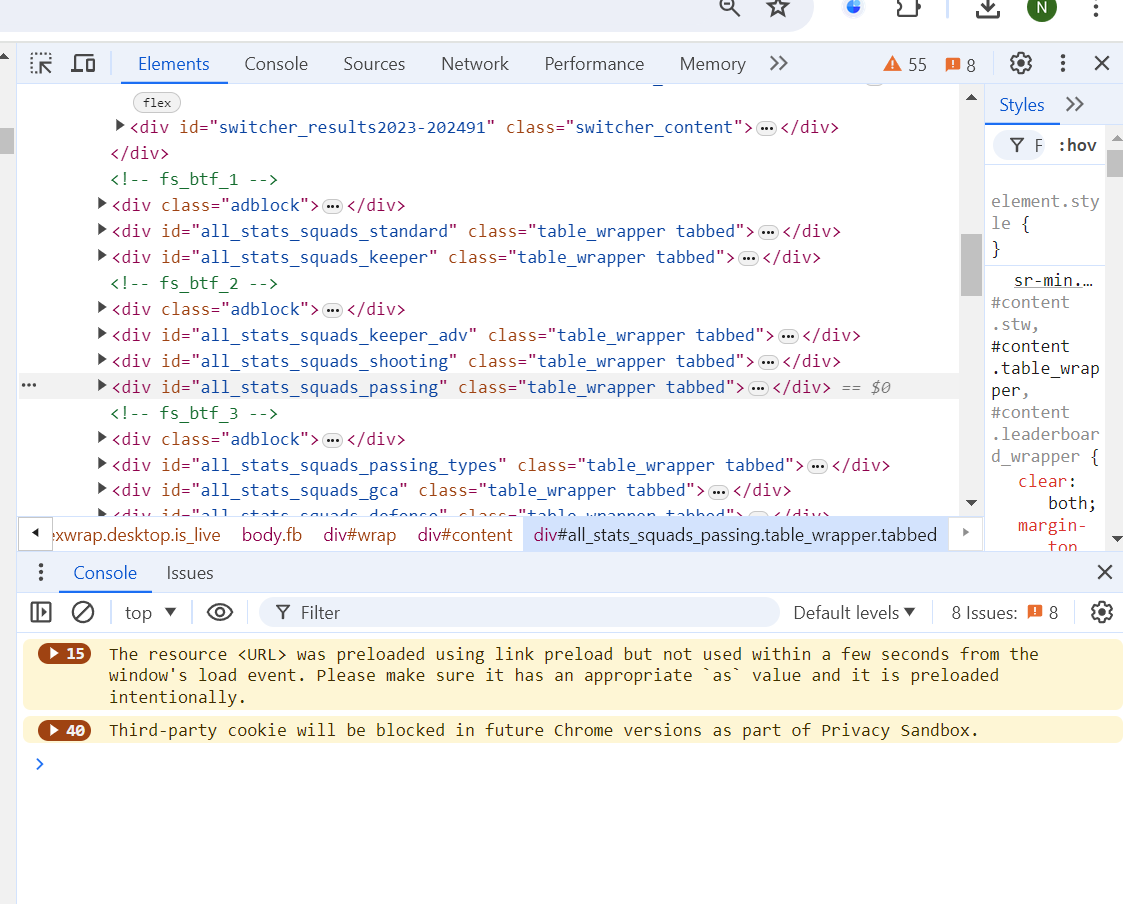

Press somewhere in the middle box and press CTRL+F to find something. Paste in results2023-202491_overall and try and find this line: 

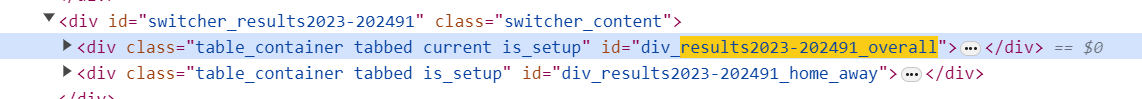

As you hover over things in this command window, what they represent is highlighted in blue on the actual webpage. Hopefully you begin to see the general idea here and how I found the table name as it is written in the webpage. For now, it should be enough if you can convince yourself that the line of code above gets the premier league table as seen on fbref. 

So great, we have the table in python now, let's start doing stuff with it:

    team_names = []
    for row in table.find_all('tr')[1:]:
        columns = row.find_all('td')
        if len(columns) > 1:
            team_names.append(columns[1].text.strip())

This chunk does what it says, just grabs all the team names, so in this case Manchester City down to Sheffield Utd. Now I want to click on the team names so I can start finding stats for each team. To do that I need to extract the hyperlinks themselves, and throw in a failsafe in case we fail:

    for link in table.find_all('a'):
        href = link.get('href')
        if href and '/en/squads' in href and team_name in link.text:
            return f'https://fbref.com{href}'

    print('Team not found')
    return None

To check if it worked, we can run the function:

In [23]:
url = get_team_url('Liverpool')
print(url)

https://fbref.com/en/squads/822bd0ba/Liverpool-Stats


That was probably a lot to digest, but hopefully you can see the end goal, we're now on https://fbref.com/en/squads/822bd0ba/Liverpool-Stats . Let's get some stats. I like looking at shooting stats, so let's find them. Scroll down until you find the table called 'Shooting'. Let's look at the next function

In [24]:
def stat_finder(team_name):
    team_url = get_team_url(team_name)
    
    # Choose specific table from team url (5 = passing | 0 = standard stats | 4 = shooting stats)
    df = pd.read_html(team_url)[4]
    df.columns = df.columns.droplevel(0)
    #df = df[df['MP'] > 15] 
    df = df[df['90s'] > 10]

    # Filter number of shots if necessary
    df = df[df['Sh'] > 10]
    df = df.iloc[:-2]

    # Drop final column
    df = df.iloc[:, :-1]

    df = df.drop(['Nation','Pos','Age'],axis=1)
    
    #df = df[['Player','KP','Ast','xAG','xA','1/3','PPA','PrgP']]
    #print(df.columns)
    return df

Another function, let's go through it.

def stat_finder(team_name):
    
    team_url = get_team_url(team_name)

So this function begins by calling the old function. So here 'team_url' returns the stats for the team of choice. 

Next we need the shooting table, and it's a lot easier than last time (just thought I'd show the hard way first :])  

```

# Choose specific table from team url (5 = passing | 0 = standard stats | 4 = shooting stats)
    df = pd.read_html(team_url)[4]

Now we can use pandas to read the html, which is much nicer. The [4] you see at the end just chooses the 5th table down (Python starts counting from 0!!!). You can see in the comment that if you change this to 5, you get passing stats, and if you change it to 0, you get the standard stats (and yes this does mean all that weird html stuff could have been done like this, hehe) Look at these tables on the website to give yourself reference here.

The next bit of code does the part you probably care about the most, actually get the stats. Let's look at the output of this function first:

In [25]:
print(stat_finder('Liverpool'))

                    Player   90s  Gls   Sh  SoT  SoT%  Sh/90  SoT/90  G/Sh  \
0          Virgil van Dijk  35.3    2   45   14  31.1   1.27    0.40  0.04   
1                Luis Díaz  29.2    8   94   32  34.0   3.22    1.10  0.09   
2      Alexis Mac Allister  28.9    5   43    8  18.6   1.49    0.28  0.09   
3            Mohamed Salah  28.2   18  107   47  43.9   3.80    1.67  0.12   
5   Trent Alexander-Arnold  23.9    3   47    8  17.0   1.96    0.33  0.06   
6       Dominik Szoboszlai  23.4    3   60   15  25.0   2.57    0.64  0.05   
7             Darwin Núñez  22.7   11  107   46  43.0   4.70    2.02  0.10   
9         Andrew Robertson  18.8    3   12    6  50.0   0.64    0.32  0.25   
10               Joe Gomez  19.8    0   19    2  10.5   0.96    0.10  0.00   
11              Cody Gakpo  18.3    8   66   24  36.4   3.60    1.31  0.12   
12         Ibrahima Konaté  17.5    0   11    2  18.2   0.63    0.11  0.00   
13            Curtis Jones  13.0    1   19    5  26.3   1.47    

So it gives us this table 

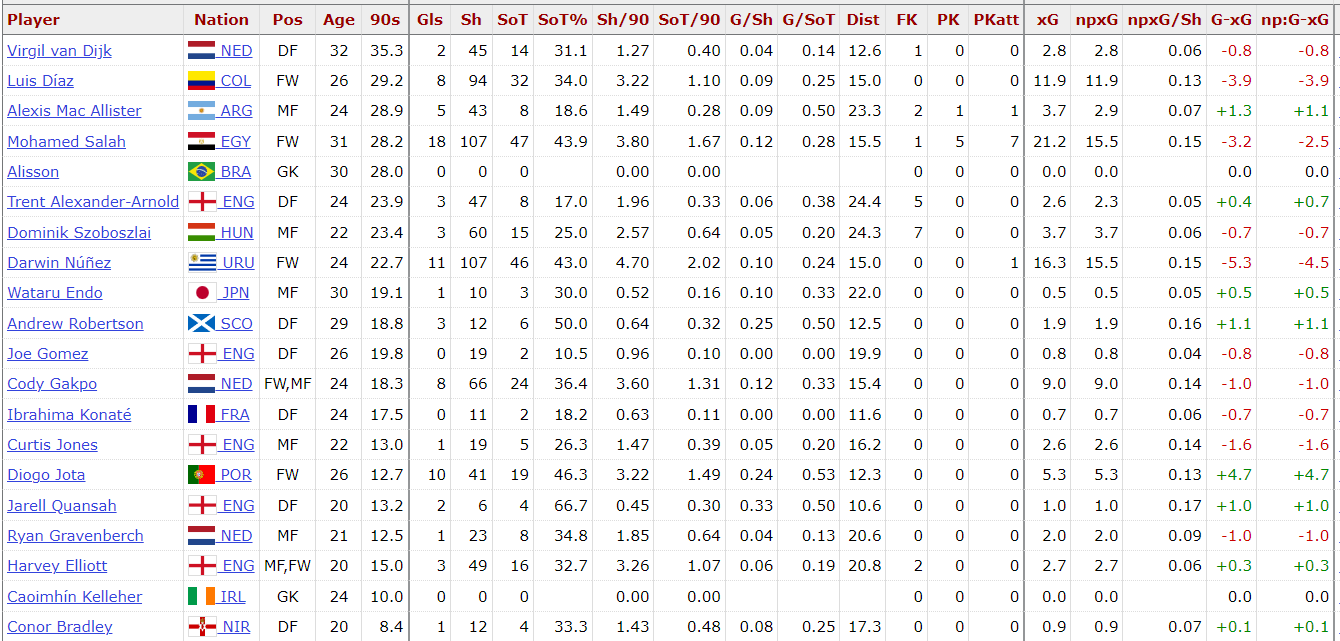

But with a few differences, and these differences are what the rest of the code is doing. For example, if I'm looking at shots, I probably do not care about players like Alisson and Quansah, so this line of code

 df = df[df['Sh'] > 10]

Gets rid of players who have shot less than 10 times this season, and

df = df.iloc[:, :-1]

drops the last column where it says 'Matches', because I don't need that. This is the same ideas as the line

 df = df.drop(['Nation','Pos','Age'],axis=1)

Which drops the Nation, Pos, and Age columns, because Van Dijk being Dutch is not very relevant to me here.

The final bit of code is how you would save this to a csv

def create_spreadsheet(team_name):
    df = stat_finder(team_name)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    df.to_csv(os.path.join(output_folder, f'{team_name}.csv'), index=False)

The idea is the df.to_csv line you see, which takes our DateFrame (df) and saves it as a csv with any title you want. Before I have just been printing out the table in the terminal, but now you can make a .csv, .xlsx or literally however you want to save this. 

Hopefully this gives an outline. The best way to do this stuff yourself is just change bits of code to see how you're impacting the outcomes. 